In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import itertools
import time
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# access folders
# I put all the images to my google drive, the data is available upon request
path_monet = "/content/drive/MyDrive/monet_paintings"
path_photo = "/content/drive/MyDrive/photos"

print("Number of monet paintings: {}".format(len(os.listdir(path_monet))))
print("Number of photos: {}".format(len(os.listdir(path_photo))))

Mounted at /content/drive
Number of monet paintings: 300
Number of photos: 7038


In [ ]:
# function to display sample images in a grid format
def display_sample_images(path, num_samples=16):
  sample_images = os.listdir(path)[:num_samples]

  w = int(num_samples ** .5)
  h = math.ceil(num_samples / w)

  for ind, image_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(path, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(h, w, ind + 1)
    plt.imshow(img)
    plt.axis("off")

  plt.show()

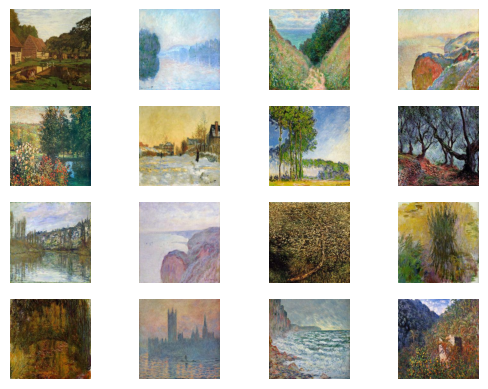

In [ ]:
display_sample_images(path_monet)

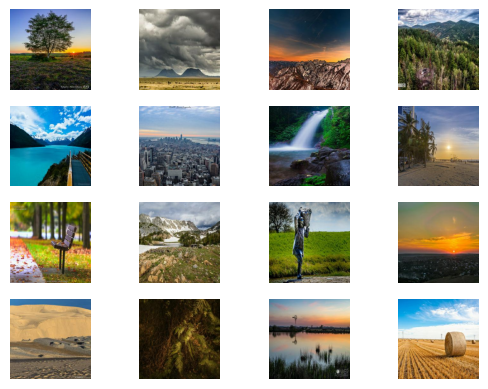

In [ ]:
display_sample_images(path_photo)

In [ ]:
# function to analyze and show the image sizes in height and width
def analyze_image_sizes(image_dir):
  image_sizes = []

  # determine image height and width
  for image_filename in os.listdir(image_dir):
    img = Image.open(os.path.join(image_dir, image_filename))
    width, height = img.size
    image_sizes.append((width, height))

  widths, heights = zip(*image_sizes)

  # plot the image widths
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.hist(widths, bins=30, color='blue', alpha=0.7)
  plt.xlabel('Image Width')
  plt.ylabel('Frequency')
  plt.title('Distribution of Image Widths')

  # plot the image heights
  plt.subplot(1, 2, 2)
  plt.hist(heights, bins=30, color='green', alpha=0.7)
  plt.xlabel('Image Height')
  plt.ylabel('Frequency')
  plt.title('Distribution of Image Heights')

  plt.tight_layout()
  plt.show()

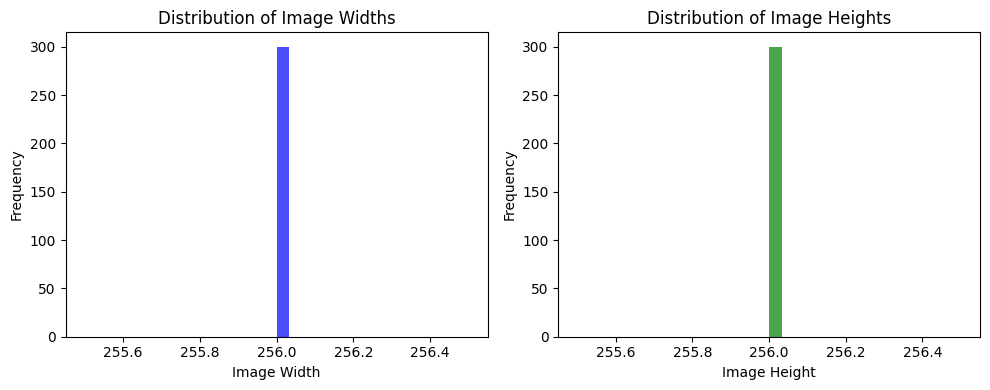

In [ ]:
analyze_image_sizes(path_monet)

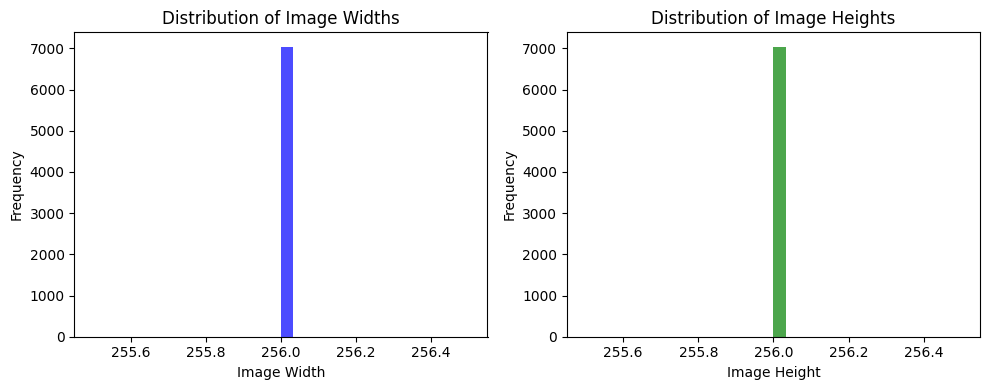

In [ ]:
analyze_image_sizes(path_photo)

In [ ]:
# function to display the present color channels in an image alongside the image itself
def display_color_channels(path):
  print(path)
  plt.figure(figsize=(16, 4))

  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(1, 4, 1)
  plt.imshow(img)
  plt.axis("off")

  colors = ["red", "green", "blue"]
  for i in range(len(colors)):
    plt.subplot(1, 4, i + 2)
    plt.hist(
      img[:, :, i].reshape(-1),
      bins=50,
      color=colors[i],
      density=True
    )
    plt.xlim(0, 255)
    plt.xticks([])
    plt.yticks([])

  plt.show()

/content/drive/MyDrive/monet_paintings/22b1ac6b44.jpg


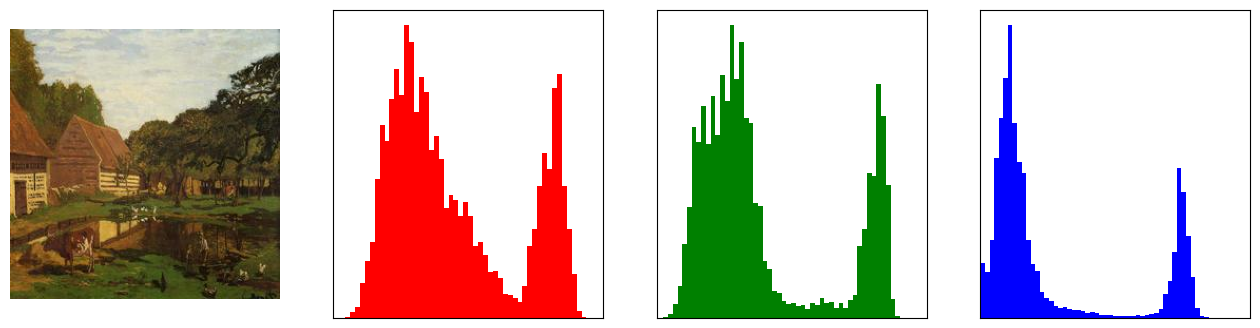

/content/drive/MyDrive/monet_paintings/0260d15306.jpg


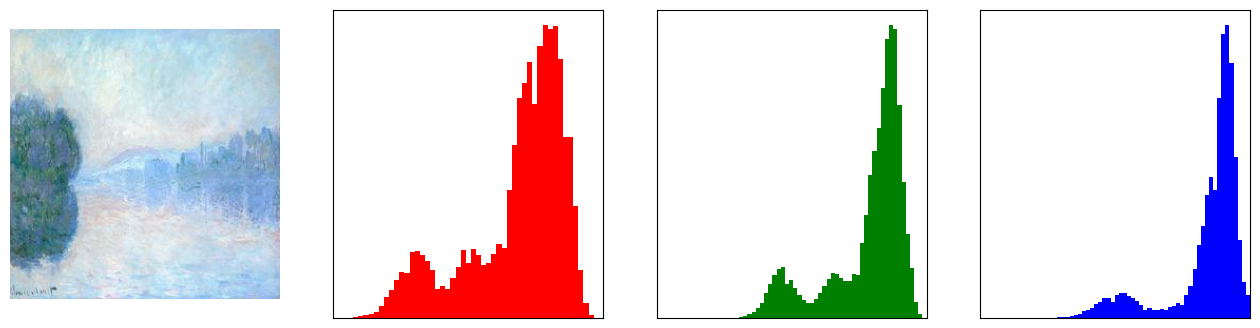

/content/drive/MyDrive/monet_paintings/1814cc6632.jpg


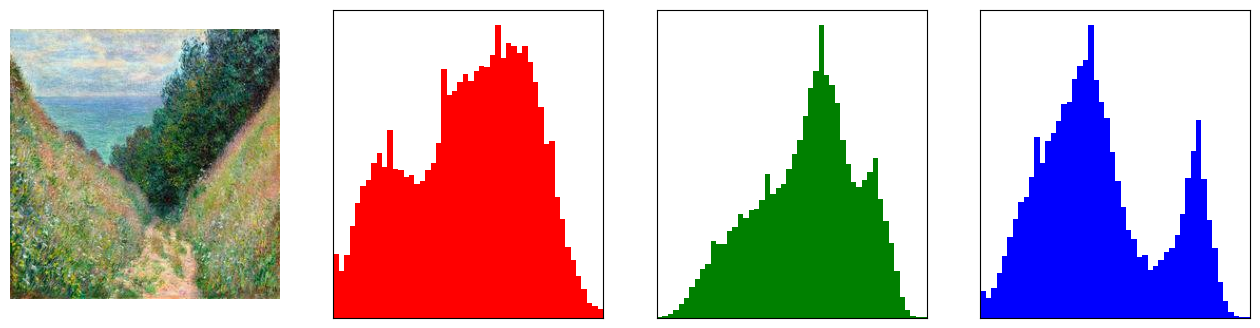

In [ ]:
# show monet example color channels
display_color_channels(path_monet + '/' + os.listdir(path_monet)[0])
display_color_channels(path_monet + '/' +os.listdir(path_monet)[1])
display_color_channels(path_monet + '/' +os.listdir(path_monet)[2])

/content/drive/MyDrive/photos/db70823e2b.jpg


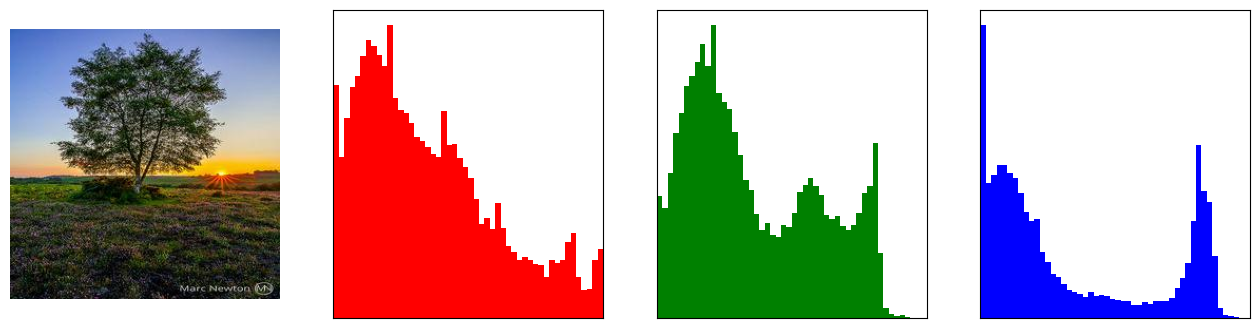

/content/drive/MyDrive/photos/db2b40dd94.jpg


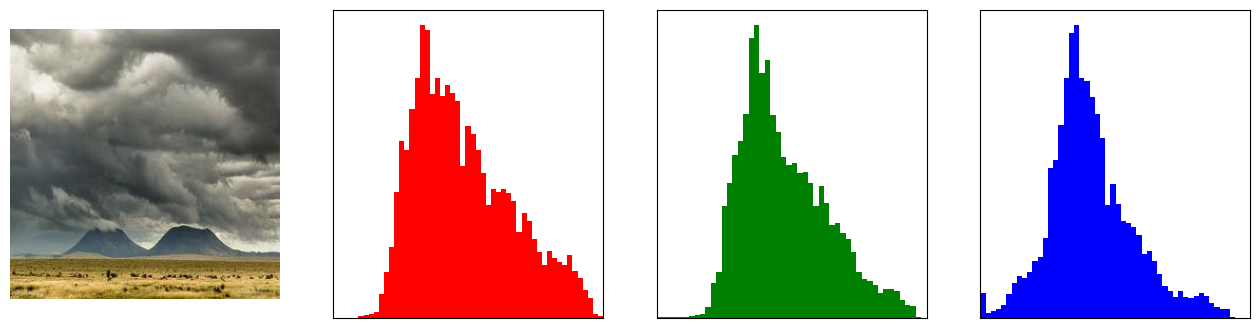

/content/drive/MyDrive/photos/dafda5c17a.jpg


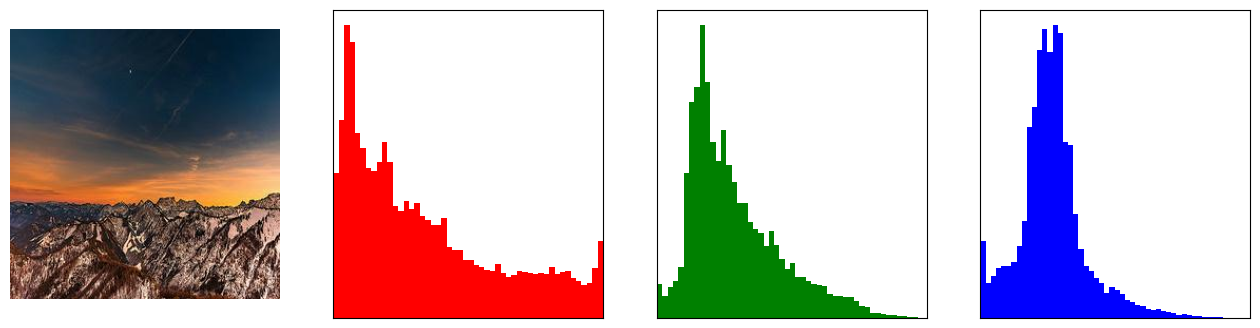

In [ ]:
# show photo example color channels
display_color_channels(path_photo + '/' + os.listdir(path_photo)[0])
display_color_channels(path_photo + '/' + os.listdir(path_photo)[1])
display_color_channels(path_photo + '/' + os.listdir(path_photo)[2])

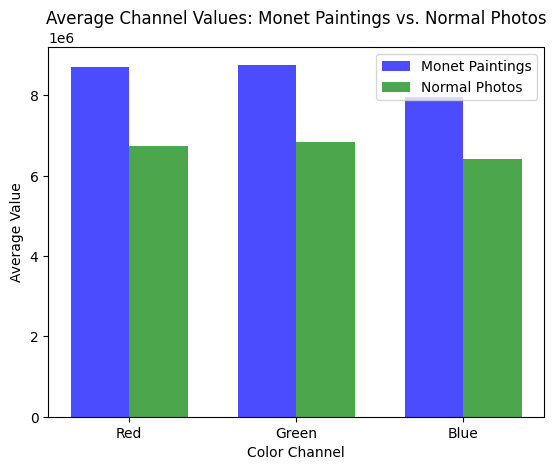

In [ ]:
# function to calculate the average channel values (Red, Green, Blue)
def calculate_average_channel_values(image_dir):

  # init each channel (R, G, B)
  channel_sum = np.zeros(3)
  total_images = 0

  for image_filename in os.listdir(image_dir):
    img = Image.open(os.path.join(image_dir, image_filename))
    img_array = np.array(img)

    # make sure it is a color image
    if img_array.shape == (256, 256, 3):
      channel_sum += np.sum(img_array, axis=(0, 1))
      total_images += 1

  average_channel_values = channel_sum / total_images
  return average_channel_values

# calculate average channel values
average_monet_values = calculate_average_channel_values(path_monet)
average_photos_values = calculate_average_channel_values(path_photo)

# ceate bar charts to compare average channel values
channels = ['Red', 'Green', 'Blue']
x = np.arange(len(channels))
width = 0.35

plt.bar(x - width/2, average_monet_values, width, label='Monet Paintings', color='b', alpha=0.7)
plt.bar(x + width/2, average_photos_values, width, label='Normal Photos', color='g', alpha=0.7)

plt.xlabel('Color Channel')
plt.ylabel('Average Value')
plt.title('Average Channel Values: Monet Paintings vs. Normal Photos')
plt.xticks(x, channels)
plt.legend()
plt.show()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used for modeling: ", device)

Device used for modeling:  cuda


In [4]:
class ImageDataset(Dataset):
  def __init__(self, path_monet, path_photo, size=(256, 256), normalize=True):
    super().__init__()
    self.monet_dir = path_monet
    self.photo_dir = path_photo
    self.monet_idx = dict()
    self.photo_idx = dict()

    # normalize the images for consistency
    if normalize:
      self.transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])
    else:
      self.transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()])

    for i, fl in enumerate(os.listdir(self.monet_dir)):
      self.monet_idx[i] = fl
    for i, fl in enumerate(os.listdir(self.photo_dir)):
      self.photo_idx[i] = fl

  # randomnly select a pair of monet painting and photo
  def __getitem__(self, idx):
    rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
    photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
    monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
    photo_img = Image.open(photo_path)
    photo_img = self.transform(photo_img)
    monet_img = Image.open(monet_path)
    monet_img = self.transform(monet_img)
    return photo_img, monet_img

  # ensure same amount of available photos
  def __len__(self):
    return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [5]:
img_ds = ImageDataset(path_monet, path_photo)
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [6]:
# reverse the normalization process
def reverse_normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
  for image, mu, std in zip(img, mean, std):
    image.mul_(std).add_(std)

  return img

In [7]:
# method for upsampling feature maps
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
  if use_dropout:
    return nn.Sequential(
      nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
      nn.InstanceNorm2d(out_ch),
      nn.Dropout(dropout_ratio),
      nn.GELU())
  else:
    return nn.Sequential(
      nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
      nn.InstanceNorm2d(out_ch),
      nn.GELU())

In [8]:
# define a convolutional layer with options for padding and more
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
  if use_pad:
    conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
  else:
    conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

  if use_leaky:
    actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
  else:
    actv = nn.GELU()

  if use_inst_norm:
    norm = nn.InstanceNorm2d(out_ch)
  else:
    norm = nn.BatchNorm2d(out_ch)

  return nn.Sequential(conv, norm, actv)

In [9]:
# defines the residual block for the generator part
class Resblock(nn.Module):
  def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
    super().__init__()
    layers = list()
    layers.append(nn.ReflectionPad2d(1))
    layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
    layers.append(nn.Dropout(dropout_ratio))
    layers.append(nn.ReflectionPad2d(1))
    layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
    layers.append(nn.InstanceNorm2d(in_features))
    self.res = nn.Sequential(*layers)

  def forward(self, x):
    return x + self.res(x)

In [10]:
# defines the generator class built upon convolutional layers
class Generator(nn.Module):
  def __init__(self, in_ch, out_ch, num_res_blocks=6):
    super().__init__()
    model = list()
    model.append(nn.ReflectionPad2d(3))
    model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
    model.append(Convlayer(64, 128, 3, 2, False))
    model.append(Convlayer(128, 256, 3, 2, False))
    for _ in range(num_res_blocks):
        model.append(Resblock(256))
    model.append(Upsample(256, 128))
    model.append(Upsample(128, 64))
    model.append(nn.ReflectionPad2d(3))
    model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
    model.append(nn.Tanh())

    self.gen = nn.Sequential(*model)

  def forward(self, x):
    return self.gen(x)

In [11]:
# defines the discriminator component
class Discriminator(nn.Module):
  def __init__(self, in_ch, num_layers=4):
    super().__init__()
    model = list()
    model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
    model.append(nn.LeakyReLU(0.2, inplace=True))
    for i in range(1, num_layers):
        in_chs = 64 * 2**(i-1)
        out_chs = in_chs * 2
        if i == num_layers -1:
            model.append(Convlayer(in_chs, out_chs, 4, 1))
        else:
            model.append(Convlayer(in_chs, out_chs, 4, 2))
    model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
    self.disc = nn.Sequential(*model)

  def forward(self, x):
    return self.disc(x)

In [12]:
# initalize with normally distributed weights around mean 0 and standard deviation of 0.02
def init_weights(net, init_type='normal', std=0.02):
  def init_func(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
      init.normal_(m.weight.data, 0.0, std)
      if hasattr(m, 'bias') and m.bias is not None:
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
      init.normal_(m.weight.data, 1.0, std)
      init.constant_(m.bias.data, 0.0)
  net.apply(init_func)

In [13]:
# decide whether certain model parameters should be trainable or not
def update_req_grad(models, requires_grad=True):
  for model in models:
    for param in model.parameters():
      param.requires_grad = requires_grad

In [14]:
# class to save 50 generated fake images and sample through them to feed discriminator
class sample_fake(object):
  def __init__(self, max_imgs=50):
    self.max_imgs = max_imgs
    self.cur_img = 0
    self.imgs = list()

  def __call__(self, imgs):
    ret = list()
    for img in imgs:
      if self.cur_img < self.max_imgs:
        self.imgs.append(img)
        ret.append(img)
        self.cur_img += 1
      else:
        if np.random.ranf() > 0.5:
          idx = np.random.randint(0, self.max_imgs)
          ret.append(self.imgs[idx])
          self.imgs[idx] = img
        else:
          ret.append(img)
    return ret

In [15]:
# class to schedule the learning rate during training
class lr_sched():
  def __init__(self, decay_epochs=100, total_epochs=200):
    self.decay_epochs = decay_epochs
    self.total_epochs = total_epochs

  def step(self, epoch_num):
    if epoch_num <= self.decay_epochs:
      return 1.0
    else:
      fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
      return 1.0 - fract

In [16]:
# class for saving some training metrics
class AvgStats(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.losses =[]
    self.its = []

  def append(self, loss, it):
    self.losses.append(loss)
    self.its.append(it)

In [17]:
# defines the Cycle GAN and its training loop
class CycleGAN(object):
  def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
    self.epochs = epochs
    self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
    self.lmbda = lmbda
    self.idt_coef = idt_coef
    self.device = device
    self.gen_mtp = Generator(in_ch, out_ch)
    self.gen_ptm = Generator(in_ch, out_ch)
    self.desc_m = Discriminator(in_ch)
    self.desc_p = Discriminator(in_ch)
    self.init_models()
    self.mse_loss = nn.MSELoss()
    self.l1_loss = nn.L1Loss()
    self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                      lr = start_lr, betas=(0.5, 0.999))
    self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                      lr=start_lr, betas=(0.5, 0.999))
    self.sample_monet = sample_fake()
    self.sample_photo = sample_fake()
    gen_lr = lr_sched(self.decay_epoch, self.epochs)
    desc_lr = lr_sched(self.decay_epoch, self.epochs)
    self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
    self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
    self.gen_stats = AvgStats()
    self.desc_stats = AvgStats()

  def init_models(self):
    init_weights(self.gen_mtp)
    init_weights(self.gen_ptm)
    init_weights(self.desc_m)
    init_weights(self.desc_p)
    self.gen_mtp = self.gen_mtp.to(self.device)
    self.gen_ptm = self.gen_ptm.to(self.device)
    self.desc_m = self.desc_m.to(self.device)
    self.desc_p = self.desc_p.to(self.device)

  def train(self, photo_dl):
    for epoch in range(self.epochs):
      start_time = time.time()
      avg_gen_loss = 0.0
      avg_desc_loss = 0.0
      t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
      for i, (photo_real, monet_real) in enumerate(t):
        photo_img, monet_img = photo_real.to(device), monet_real.to(device)
        update_req_grad([self.desc_m, self.desc_p], False)
        self.adam_gen.zero_grad()

        # forward pass through generator
        fake_photo = self.gen_mtp(monet_img)
        fake_monet = self.gen_ptm(photo_img)

        cycl_monet = self.gen_ptm(fake_photo)
        cycl_photo = self.gen_mtp(fake_monet)

        id_monet = self.gen_ptm(monet_img)
        id_photo = self.gen_mtp(photo_img)

        # generator losses
        idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
        idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

        cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
        cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

        monet_desc = self.desc_m(fake_monet)
        photo_desc = self.desc_p(fake_photo)

        real = torch.ones(monet_desc.size()).to(self.device)

        adv_loss_monet = self.mse_loss(monet_desc, real)
        adv_loss_photo = self.mse_loss(photo_desc, real)

        # total generator loss
        total_gen_loss = cycle_loss_monet + adv_loss_monet\
                + cycle_loss_photo + adv_loss_photo\
                + idt_loss_monet + idt_loss_photo

        avg_gen_loss += total_gen_loss.item()

        # backward pass
        total_gen_loss.backward()
        self.adam_gen.step()

        # forward pass through Descriminator
        update_req_grad([self.desc_m, self.desc_p], True)
        self.adam_desc.zero_grad()

        fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
        fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
        fake_monet = torch.tensor(fake_monet).to(self.device)
        fake_photo = torch.tensor(fake_photo).to(self.device)

        monet_desc_real = self.desc_m(monet_img)
        monet_desc_fake = self.desc_m(fake_monet)
        photo_desc_real = self.desc_p(photo_img)
        photo_desc_fake = self.desc_p(fake_photo)

        real = torch.ones(monet_desc_real.size()).to(self.device)
        fake = torch.zeros(monet_desc_fake.size()).to(self.device)

        # descriminator losses
        monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
        monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
        photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
        photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

        monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
        photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
        total_desc_loss = monet_desc_loss + photo_desc_loss
        avg_desc_loss += total_desc_loss.item()

        # backward
        monet_desc_loss.backward()
        photo_desc_loss.backward()
        self.adam_desc.step()

        t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

      avg_gen_loss /= photo_dl.__len__()
      avg_desc_loss /= photo_dl.__len__()
      time_req = time.time() - start_time

      self.gen_stats.append(avg_gen_loss, time_req)
      self.desc_stats.append(avg_desc_loss, time_req)

      print("Epoch %d  -  Generator Loss:%f  -  Discriminator Loss:%f" % (epoch+1, avg_gen_loss, avg_desc_loss))

      self.gen_lr_sched.step()
      self.desc_lr_sched.step()

In [ ]:
gan = CycleGAN(3, 3, 100, device)
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1  -  Generator Loss:11.651616  -  Discriminator Loss:0.885696


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2  -  Generator Loss:9.720744  -  Discriminator Loss:0.433638


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3  -  Generator Loss:9.285568  -  Discriminator Loss:0.399582


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 4  -  Generator Loss:8.834084  -  Discriminator Loss:0.384258


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 5  -  Generator Loss:8.511062  -  Discriminator Loss:0.410186


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 6  -  Generator Loss:8.125051  -  Discriminator Loss:0.423948


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 7  -  Generator Loss:7.912354  -  Discriminator Loss:0.422915


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 8  -  Generator Loss:7.883517  -  Discriminator Loss:0.416012


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 9  -  Generator Loss:7.616783  -  Discriminator Loss:0.412471


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 10  -  Generator Loss:7.558008  -  Discriminator Loss:0.406424


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 11  -  Generator Loss:7.507478  -  Discriminator Loss:0.419537


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 12  -  Generator Loss:7.289117  -  Discriminator Loss:0.414411


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 13  -  Generator Loss:7.250143  -  Discriminator Loss:0.412692


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 14  -  Generator Loss:7.192928  -  Discriminator Loss:0.403866


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 15  -  Generator Loss:7.058887  -  Discriminator Loss:0.405782


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 16  -  Generator Loss:7.121475  -  Discriminator Loss:0.403217


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 17  -  Generator Loss:6.890541  -  Discriminator Loss:0.394383


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 18  -  Generator Loss:6.956788  -  Discriminator Loss:0.399733


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 19  -  Generator Loss:6.966892  -  Discriminator Loss:0.392324


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 20  -  Generator Loss:6.806029  -  Discriminator Loss:0.387866


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 21  -  Generator Loss:6.790808  -  Discriminator Loss:0.381269


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 22  -  Generator Loss:6.836301  -  Discriminator Loss:0.366494


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 23  -  Generator Loss:6.893970  -  Discriminator Loss:0.360277


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 24  -  Generator Loss:6.763471  -  Discriminator Loss:0.353151


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 25  -  Generator Loss:6.652417  -  Discriminator Loss:0.358609


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 26  -  Generator Loss:6.775473  -  Discriminator Loss:0.368416


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 27  -  Generator Loss:6.645027  -  Discriminator Loss:0.364491


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 28  -  Generator Loss:6.452522  -  Discriminator Loss:0.354416


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 29  -  Generator Loss:6.556015  -  Discriminator Loss:0.354574


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 30  -  Generator Loss:6.538018  -  Discriminator Loss:0.359115


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 31  -  Generator Loss:6.436141  -  Discriminator Loss:0.355564


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 32  -  Generator Loss:6.501397  -  Discriminator Loss:0.359615


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 33  -  Generator Loss:6.405237  -  Discriminator Loss:0.338523


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 34  -  Generator Loss:6.433257  -  Discriminator Loss:0.345480


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 35  -  Generator Loss:6.223037  -  Discriminator Loss:0.338423


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 36  -  Generator Loss:6.445885  -  Discriminator Loss:0.330883


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 37  -  Generator Loss:6.402861  -  Discriminator Loss:0.326440


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 38  -  Generator Loss:6.319560  -  Discriminator Loss:0.350614


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 39  -  Generator Loss:6.357860  -  Discriminator Loss:0.335953


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 40  -  Generator Loss:6.261936  -  Discriminator Loss:0.316824


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 41  -  Generator Loss:6.282490  -  Discriminator Loss:0.326072


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 42  -  Generator Loss:6.155178  -  Discriminator Loss:0.323470


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 43  -  Generator Loss:6.236983  -  Discriminator Loss:0.307340


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 44  -  Generator Loss:6.200904  -  Discriminator Loss:0.317817


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 45  -  Generator Loss:6.105218  -  Discriminator Loss:0.309431


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 46  -  Generator Loss:6.178681  -  Discriminator Loss:0.310047


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 47  -  Generator Loss:6.232188  -  Discriminator Loss:0.295036


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 48  -  Generator Loss:6.221778  -  Discriminator Loss:0.289535


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 49  -  Generator Loss:6.035266  -  Discriminator Loss:0.297837


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 50  -  Generator Loss:6.170090  -  Discriminator Loss:0.304655


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 51  -  Generator Loss:6.114302  -  Discriminator Loss:0.278447


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 52  -  Generator Loss:6.083513  -  Discriminator Loss:0.278416


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 53  -  Generator Loss:6.114434  -  Discriminator Loss:0.265021


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 54  -  Generator Loss:6.131901  -  Discriminator Loss:0.265667


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 55  -  Generator Loss:6.199548  -  Discriminator Loss:0.215872


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 56  -  Generator Loss:6.202522  -  Discriminator Loss:0.239316


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 57  -  Generator Loss:6.136799  -  Discriminator Loss:0.220140


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 58  -  Generator Loss:6.037959  -  Discriminator Loss:0.215221


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 59  -  Generator Loss:6.016798  -  Discriminator Loss:0.207340


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 60  -  Generator Loss:6.057589  -  Discriminator Loss:0.174179


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 61  -  Generator Loss:6.022956  -  Discriminator Loss:0.181649


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 62  -  Generator Loss:6.007206  -  Discriminator Loss:0.180051


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 63  -  Generator Loss:5.959924  -  Discriminator Loss:0.173506


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 64  -  Generator Loss:5.994410  -  Discriminator Loss:0.174003


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 65  -  Generator Loss:5.952074  -  Discriminator Loss:0.170862


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 66  -  Generator Loss:5.955434  -  Discriminator Loss:0.156847


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 67  -  Generator Loss:5.989858  -  Discriminator Loss:0.170224


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 68  -  Generator Loss:5.894134  -  Discriminator Loss:0.155859


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 69  -  Generator Loss:5.869687  -  Discriminator Loss:0.159299


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 70  -  Generator Loss:5.819040  -  Discriminator Loss:0.150041


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 71  -  Generator Loss:5.857230  -  Discriminator Loss:0.138094


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 72  -  Generator Loss:5.903640  -  Discriminator Loss:0.151930


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 73  -  Generator Loss:5.810691  -  Discriminator Loss:0.124834


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 74  -  Generator Loss:5.850806  -  Discriminator Loss:0.132908


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 75  -  Generator Loss:5.797474  -  Discriminator Loss:0.122669


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 76  -  Generator Loss:5.803793  -  Discriminator Loss:0.134603


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 77  -  Generator Loss:5.737983  -  Discriminator Loss:0.121279


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 78  -  Generator Loss:5.733461  -  Discriminator Loss:0.115752


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 79  -  Generator Loss:5.768905  -  Discriminator Loss:0.102658


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 80  -  Generator Loss:5.695924  -  Discriminator Loss:0.111651


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 81  -  Generator Loss:5.746437  -  Discriminator Loss:0.099292


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 82  -  Generator Loss:5.702490  -  Discriminator Loss:0.099533


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 83  -  Generator Loss:5.721655  -  Discriminator Loss:0.095308


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 84  -  Generator Loss:5.669921  -  Discriminator Loss:0.089769


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 85  -  Generator Loss:5.682162  -  Discriminator Loss:0.092933


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 86  -  Generator Loss:5.682648  -  Discriminator Loss:0.093101


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 87  -  Generator Loss:5.723362  -  Discriminator Loss:0.087088


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 88  -  Generator Loss:5.636714  -  Discriminator Loss:0.082462


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 89  -  Generator Loss:5.649106  -  Discriminator Loss:0.082728


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 90  -  Generator Loss:5.687875  -  Discriminator Loss:0.078270


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 91  -  Generator Loss:5.696587  -  Discriminator Loss:0.078554


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 92  -  Generator Loss:5.710340  -  Discriminator Loss:0.078053


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 93  -  Generator Loss:5.700975  -  Discriminator Loss:0.075717


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 94  -  Generator Loss:5.698136  -  Discriminator Loss:0.073425


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 95  -  Generator Loss:5.679524  -  Discriminator Loss:0.066021


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 96  -  Generator Loss:5.665868  -  Discriminator Loss:0.068039


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 97  -  Generator Loss:5.654271  -  Discriminator Loss:0.067130


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 98  -  Generator Loss:5.734758  -  Discriminator Loss:0.060836


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 99  -  Generator Loss:5.687852  -  Discriminator Loss:0.054979


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 100  -  Generator Loss:5.729666  -  Discriminator Loss:0.058015


In [ ]:
checkpoint = {
  "gen_mtp": gan.gen_mtp.state_dict(),   # Monet → Photo
  "gen_ptm": gan.gen_ptm.state_dict(),   # Photo → Monet
  "desc_m": gan.desc_m.state_dict(),     # Discriminator Monet
  "desc_p": gan.desc_p.state_dict(),     # Discriminator Photo
  "opt_gen": gan.adam_gen.state_dict(),  # Generator optimizer
  "opt_desc": gan.adam_desc.state_dict(),# Discriminator optimizer                        # current epoch
}

torch.save(checkpoint, "cyclegan_checkpoint.pth")
print("✅ CycleGAN checkpoint saved!")

✅ CycleGAN checkpoint saved!


In [20]:
gan = CycleGAN(3, 3, 100, device)  # must match your constructor arguments

checkpoint = torch.load("cyclegan_checkpoint.pth", map_location=device)

gan.gen_mtp.load_state_dict(checkpoint["gen_mtp"])
gan.gen_ptm.load_state_dict(checkpoint["gen_ptm"])
gan.desc_m.load_state_dict(checkpoint["desc_m"])
gan.desc_p.load_state_dict(checkpoint["desc_p"])

gan.adam_gen.load_state_dict(checkpoint["opt_gen"])
gan.adam_desc.load_state_dict(checkpoint["opt_desc"])
print("✅ CycleGAN loaded!")

✅ CycleGAN loaded!


In [21]:
# plot losses
def plot_gan_loss():
  plt.xlabel("Epochs")
  plt.ylabel("Losses")
  plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
  plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
  plt.legend()
  plt.show()

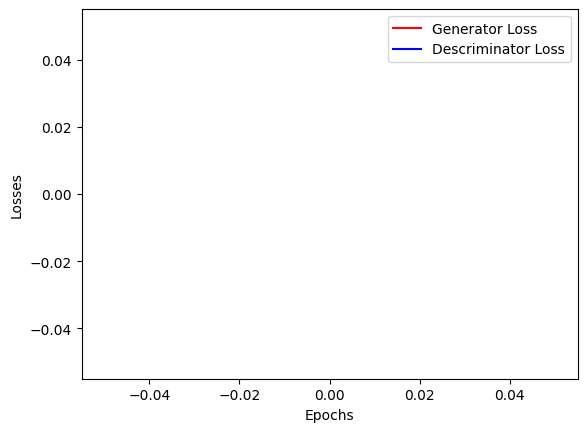

In [22]:
plot_gan_loss()

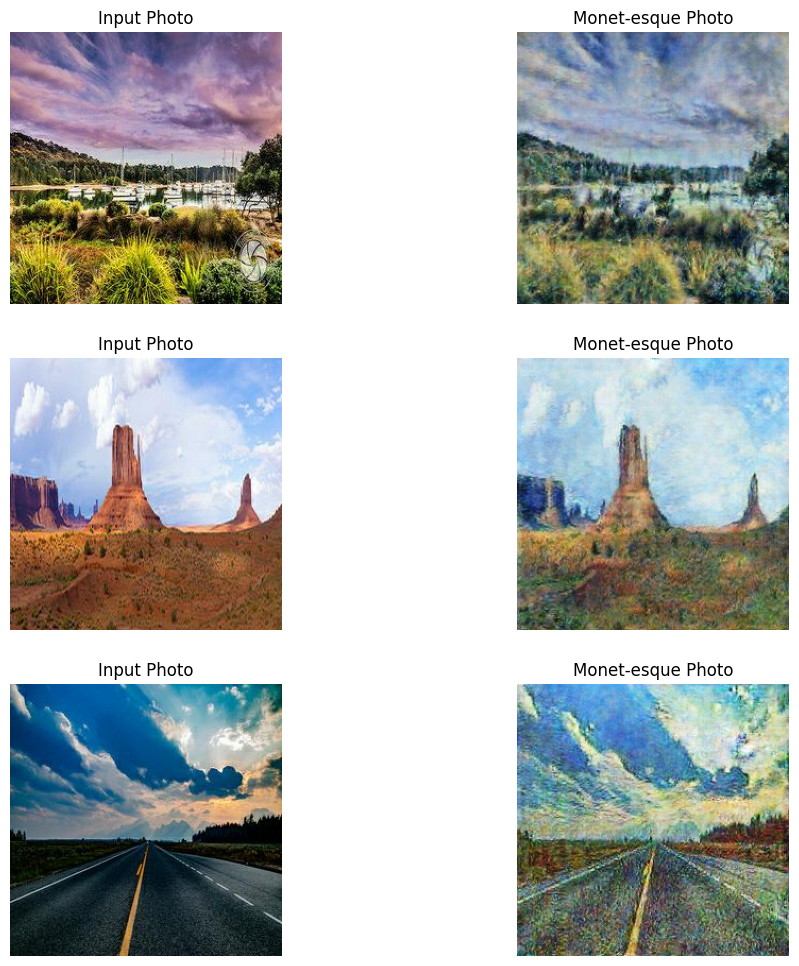

In [23]:
# plot realistic photo and created monet-style image
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i in range(5):
  photo_img, _ = next(iter(img_dl))
  pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
  photo_img = reverse_normalize(photo_img)
  pred_monet = reverse_normalize(pred_monet)

  ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
  ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
  ax[i, 0].set_title("Input Photo")
  ax[i, 1].set_title("Monet style Photo")
  ax[i, 0].axis("off")
  ax[i, 1].axis("off")
plt.show()

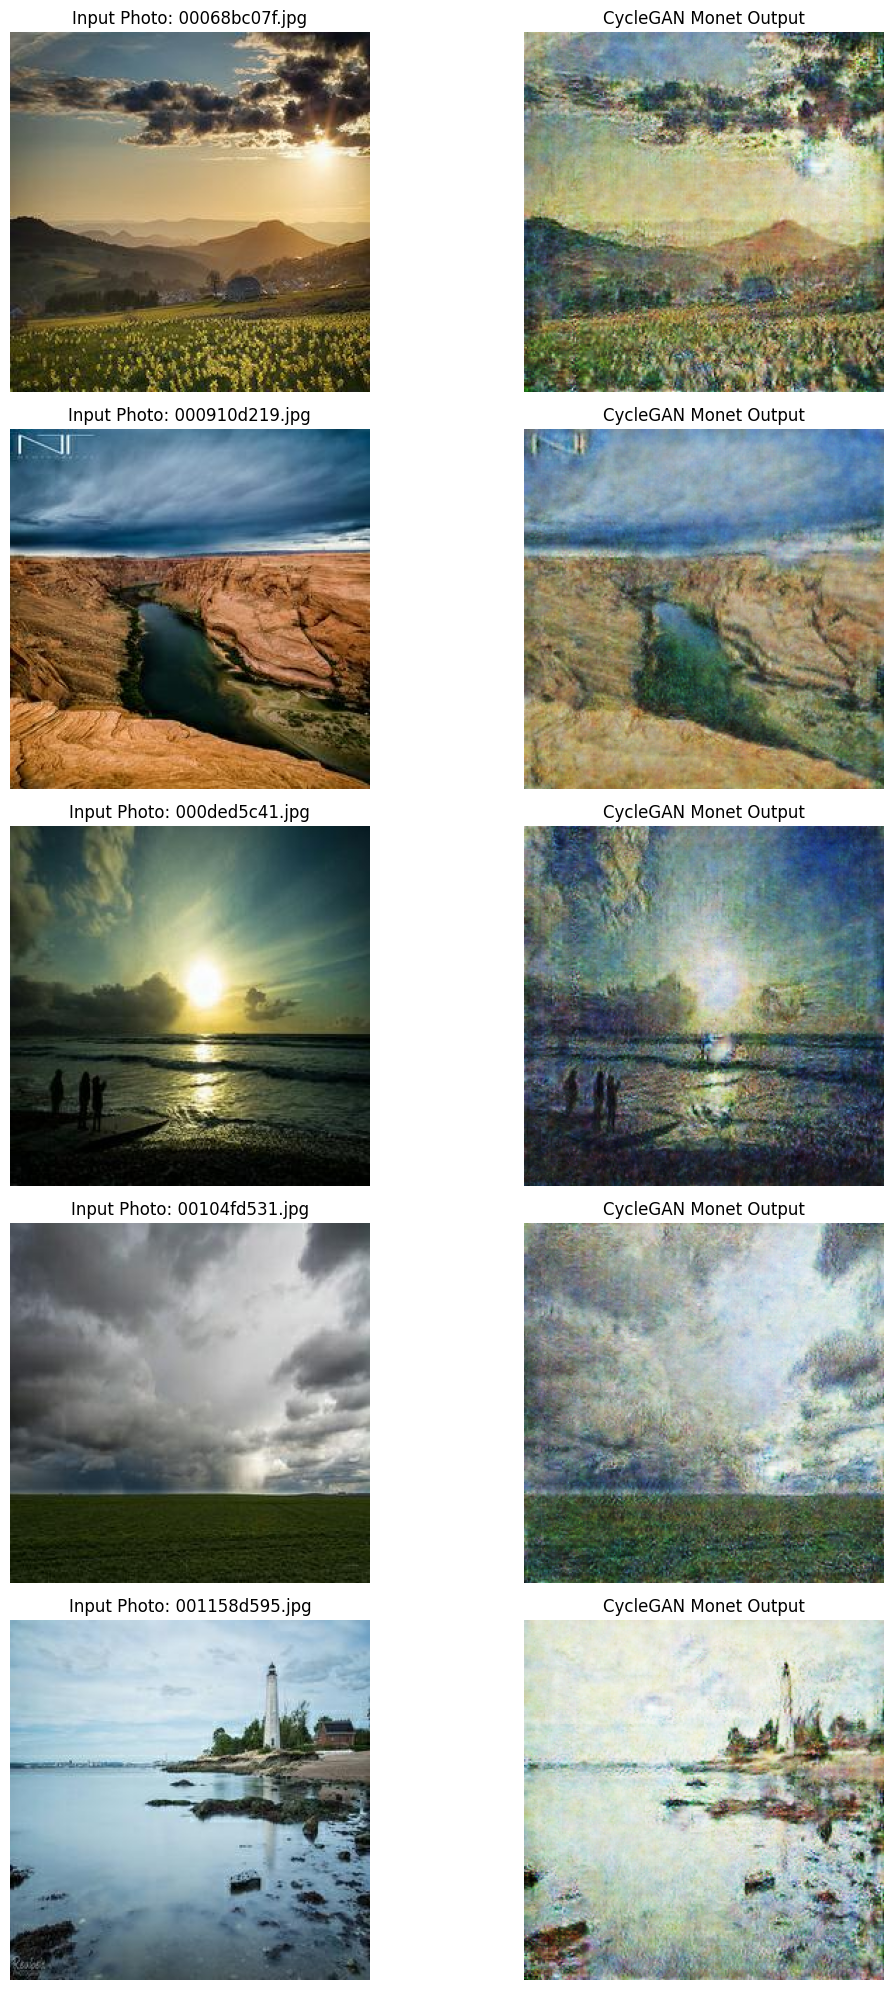

In [29]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch

# --- Use your dataset’s transform ---
transform = img_ds.transform    # <- your exact transform

def load_and_preprocess(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)   # shape (1,3,256,256)

# --- Get first 5 photo files deterministically ---
photo_files = [
    f for f in os.listdir(path_photo)
    if f.lower().endswith((".jpg",".jpeg",".png"))
]
photo_files = sorted(photo_files)[:5]

fig, ax = plt.subplots(5, 2, figsize=(12, 20))

for i, fname in enumerate(photo_files):
    photo_path = os.path.join(path_photo, fname)

    # Load & preprocess
    photo_img = load_and_preprocess(photo_path).to(device)

    # CycleGAN inference
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo_img)

    # 👉 MOVE TO CPU before converting to numpy
    photo_vis = reverse_normalize(photo_img.cpu())[0]       # CPU now
    monet_vis = reverse_normalize(pred_monet.cpu())[0]      # CPU now

    # --- Plot original ---
    ax[i, 0].imshow(photo_vis.permute(1, 2, 0).numpy())
    ax[i, 0].set_title(f"Input Photo: {fname}")
    ax[i, 0].axis("off")

    # --- Plot Monet output ---
    ax[i, 1].imshow(monet_vis.permute(1, 2, 0).numpy())
    ax[i, 1].set_title("CycleGAN Monet Output")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [30]:
# class to store and access the photos (similar to the paintings done before)
class PhotoDataset(Dataset):
  def __init__(self, photo_dir, size=(256, 256), normalize=True):
    super().__init__()
    self.photo_dir = photo_dir
    self.photo_idx = dict()

    # normalize images if needed
    if normalize:
      self.transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])
    else:
      self.transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
      ])
    for i, fl in enumerate(os.listdir(self.photo_dir)):
      self.photo_idx[i] = fl

  # retrieve an image
  def __getitem__(self, idx):
    photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
    photo_img = Image.open(photo_path)
    photo_img = self.transform(photo_img)
    return photo_img

  def __len__(self):
    return len(self.photo_idx.keys())

In [31]:
# make a dataloader and the required directory for storing the images to be created
ph_ds = PhotoDataset(path_photo)
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)
# !mkdir ../images
trans = transforms.ToPILImage()

In [33]:
# use model to create a monet style image
save_dir = "/content/drive/MyDrive/project_outputs/gan"
os.makedirs(save_dir, exist_ok=True)

# t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
t = tqdm(ph_dl, leave=False)
num_to_generate = 11
for i, photo in enumerate(t):
  if i >= num_to_generate:
    break
  with torch.no_grad():
    pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()

  # revert the normalization process to obtain the original image style
  pred_monet = reverse_normalize(pred_monet)
  img = trans(pred_monet[0]).convert("RGB")

  # store the image
  # img.save("/content/drive/MyDrive/project_outputs/diffusion")
  img.save(os.path.join(save_dir, f"gen_{i:02d}.png"))

  0%|          | 0/7038 [00:00<?, ?it/s]

In [34]:
!pip install clean-fid

In [35]:
from cleanfid import fid

real_dir = "/content/drive/MyDrive/monet_paintings"
gen_dir  = "/content/drive/MyDrive/project_outputs/gan"

fid_score = fid.compute_fid(real_dir, gen_dir)
print("FID =", fid_score)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 300 images in the folder /content/drive/MyDrive/monet_paintings


FID monet_paintings : 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Found 11 images in the folder /content/drive/MyDrive/project_outputs/gan


FID gan : 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


FID = 256.44389516214943
